In [7]:
import matplotlib
import numpy as np
import pandas as pd
import itertools
import sklearn
import keras
import time
import shap
import datetime

from keras.models import Sequential
from keras.layers import Dense, Dropout, CuDNNLSTM, Conv1D
from matplotlib import pyplot as plt
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_finance import candlestick_ohlc
import seaborn as sns

print('Numpy version: ' + np.__version__)
print('Pandas version: ' + pd.__version__)
print('Matplotlib version: ' + matplotlib.__version__)
print('Sklearn version: ' + sklearn.__version__)
print('Keras version: ' + keras.__version__)

Numpy version: 1.16.4
Pandas version: 0.24.2
Matplotlib version: 3.1.0
Sklearn version: 0.21.2
Keras version: 2.2.4


In [8]:
from plot_stats import get_model_insights

Numpy version: 1.16.4
Pandas version: 0.24.2
Matplotlib version: 3.1.0
Sklearn version: 0.21.2
Keras version: 2.2.4


get_model_insights(my_model,training_history,alpha_distance,X_input,Y_output,Y_datetimes):

In [9]:
def ohlc_to_candlestick(conversion_array):
    candlestick_data = [0,0,0,0]
    
    if conversion_array[4]>conversion_array[1]:
        candle_type=1
        wicks_up=conversion_array[2]-conversion_array[4]
        wicks_down=conversion_array[3]-conversion_array[1]
        body_size=conversion_array[4]-conversion_array[1]
        
    else:
        candle_type=0
        wicks_up=conversion_array[2]-conversion_array[1]
        wicks_down=conversion_array[3]-conversion_array[4]
        body_size=conversion_array[2]-conversion_array[4]

    
    if wicks_up < 0:wicks_up=wicks_up*(-1)
    if wicks_down < 0:wicks_down=wicks_down*(-1)
    if body_size < 0:body_size=body_size*(-1)
    candlestick_data[0]=candle_type
    candlestick_data[1]=round(round(wicks_up,5)*10000,2)
    candlestick_data[2]=round(round(wicks_down,5)*10000,2)
    candlestick_data[3]=round(round(body_size,5)*10000,2)
    
    return candlestick_data

In [10]:
def my_generator_candle_X_Y(data,lookback,MinMax = False,Multi=False):
    if MinMax==True:scaler = preprocessing.MinMaxScaler()
    first_row = 0
    arr = np.empty((0,lookback,4))
    arr3 = np.empty((0,lookback,5))
    Y_list = []
    Y_dates_list = []
    for a in range(len(data)-lookback):
        temp_list = []
        temp_list_raw = []
        for candle in data[first_row:first_row+lookback]:
            converted_data = ohlc_to_candlestick(candle)
            temp_list.append(converted_data)
            temp_list_raw.append(candle)
        temp_list3 = [np.asarray(temp_list)]
        templist4 = np.asarray(temp_list3)
        
        if MinMax==True:
            templist99 = scaler.fit_transform(templist4[0])
            arr = np.append(arr, [templist99], axis=0)
        else:    
            arr = np.append(arr, templist4, axis=0)
        
        temp_list7 = [np.asarray(temp_list_raw)]
        templist8 = np.asarray(temp_list7)
        arr3 = np.append(arr3, templist8, axis=0)

        converted_data_prediction = ohlc_to_candlestick(data[first_row+lookback])
        Prediction = converted_data_prediction[0]
        if Multi==True:
            if Prediction== 1: Prediction=[1,0]
            if Prediction== 0: Prediction=[0,1]
            Y_list.append(np.asarray(Prediction))
        if Multi==False:  
            Y_list.append(Prediction)
        
        
        Y_dates_list.append(data[first_row+lookback][0])
        
        first_row=first_row+1

    arr2 = np.asarray(Y_list)
    arr4 = np.asarray(Y_dates_list)
    
    return arr,arr2,arr3,arr4

In [48]:
len(EURUSD_dataset)/16

6322.5

In [11]:
EURUSD_dataset = pd.read_csv('Hour/EURUSD.csv')
del EURUSD_dataset['Volume']
print(len(EURUSD_dataset))

101160


In [49]:
EURUSD_train=EURUSD_dataset[:10000]
EURUSD_val=EURUSD_dataset[10000:20000]
EURUSD_test=EURUSD_dataset[20000:]

In [50]:
X_val,Y_val, X_raw_val, Y_dates_val = my_generator_candle_X_Y(EURUSD_train.values,9,MinMax=False,Multi=True)

In [51]:
X_train,Y_train, X_raw_train, Y_dates_train = my_generator_candle_X_Y(EURUSD_val.values,9,MinMax=False,Multi=True)

In [52]:
X_test,Y_test, X_raw_test, Y_dates_test = my_generator_candle_X_Y(EURUSD_test.values,9,MinMax=False,Multi=True)

In [53]:
X_train

array([[[ 0. ,  2.9,  1.8, 27.7],
        [ 0. ,  1.2, 15.2,  9.4],
        [ 1. , 10.8, 12.6,  8.8],
        ...,
        [ 0. ,  4.2,  4.9,  5.9],
        [ 0. ,  7.6,  2.8, 12.8],
        [ 1. ,  3.9,  4.1,  4.9]],

       [[ 0. ,  1.2, 15.2,  9.4],
        [ 1. , 10.8, 12.6,  8.8],
        [ 0. ,  1. ,  7. , 14.6],
        ...,
        [ 0. ,  7.6,  2.8, 12.8],
        [ 1. ,  3.9,  4.1,  4.9],
        [ 1. ,  4. ,  5.4,  4.6]],

       [[ 1. , 10.8, 12.6,  8.8],
        [ 0. ,  1. ,  7. , 14.6],
        [ 0. , 10.8,  5.9, 11.4],
        ...,
        [ 1. ,  3.9,  4.1,  4.9],
        [ 1. ,  4. ,  5.4,  4.6],
        [ 0. ,  2.7,  3.6, 11.9]],

       ...,

       [[ 0. , 10.3,  7.2, 13.3],
        [ 1. ,  2.8,  4.7,  4.3],
        [ 1. ,  0.9,  3. ,  2.5],
        ...,
        [ 0. ,  1.7,  2.8, 14.2],
        [ 1. ,  3.5,  1.1,  6.6],
        [ 1. ,  2.5,  1.3, 11.9]],

       [[ 1. ,  2.8,  4.7,  4.3],
        [ 1. ,  0.9,  3. ,  2.5],
        [ 1. ,  3. ,  5. ,  1.5],
        .

In [54]:
Y_train

array([[1, 0],
       [0, 1],
       [0, 1],
       ...,
       [0, 1],
       [0, 1],
       [1, 0]])

In [55]:
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()

model.add(layers.CuDNNLSTM(units = 64,return_sequences=True, input_shape = (None, X_train.shape[-1])))
model.add(layers.BatchNormalization()) 
model.add(Dropout(0.3))
model.add(layers.CuDNNLSTM(units = 64,return_sequences=True,))
model.add(layers.BatchNormalization()) 
model.add(Dropout(0.2))
model.add(layers.CuDNNLSTM(units = 12,return_sequences=True))
model.add(layers.BatchNormalization()) 
model.add(layers.CuDNNLSTM(units = 6))


model.add(layers.Dense(units = 2,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [56]:
history = model.fit(X_train, Y_train,batch_size=500, epochs=30,validation_data=(X_val, Y_val))
#test=get_model_insights(model,history,0.4,X_test,Y_test,Y_dates_test)

Train on 9991 samples, validate on 9991 samples
Epoch 1/30
9991/9991 [==============================] - 4s 359us/step - loss: 0.7012 - acc: 0.4972 - val_loss: 0.6959 - val_acc: 0.5068
Epoch 2/30
9991/9991 [==============================] - 1s 96us/step - loss: 0.6940 - acc: 0.5139 - val_loss: 0.6949 - val_acc: 0.5037
Epoch 3/30
9991/9991 [==============================] - 1s 97us/step - loss: 0.6928 - acc: 0.5161 - val_loss: 0.6946 - val_acc: 0.5077
Epoch 4/30
9991/9991 [==============================] - 1s 97us/step - loss: 0.6920 - acc: 0.5205 - val_loss: 0.6943 - val_acc: 0.5067
Epoch 5/30
9991/9991 [==============================] - 1s 98us/step - loss: 0.6912 - acc: 0.5231 - val_loss: 0.6954 - val_acc: 0.5094
Epoch 6/30
9991/9991 [==============================] - 1s 99us/step - loss: 0.6908 - acc: 0.5291 - val_loss: 0.6948 - val_acc: 0.5053
Epoch 7/30
9991/9991 [==============================] - 1s 98us/step - loss: 0.6888 - acc: 0.5360 - val_loss: 0.6951 - val_acc: 0.5089
Epoch 

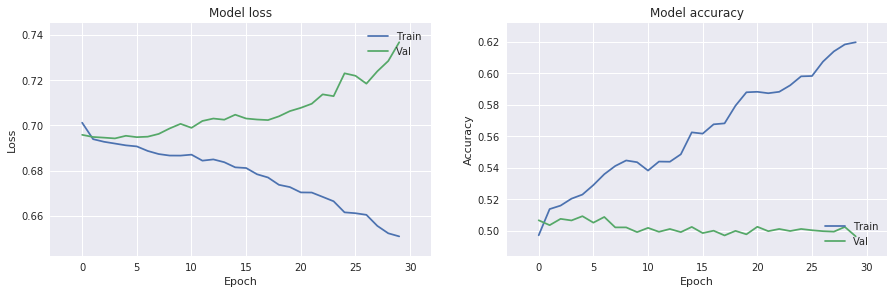

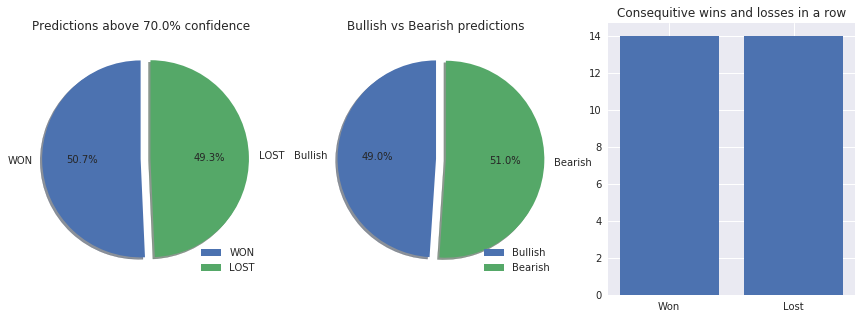

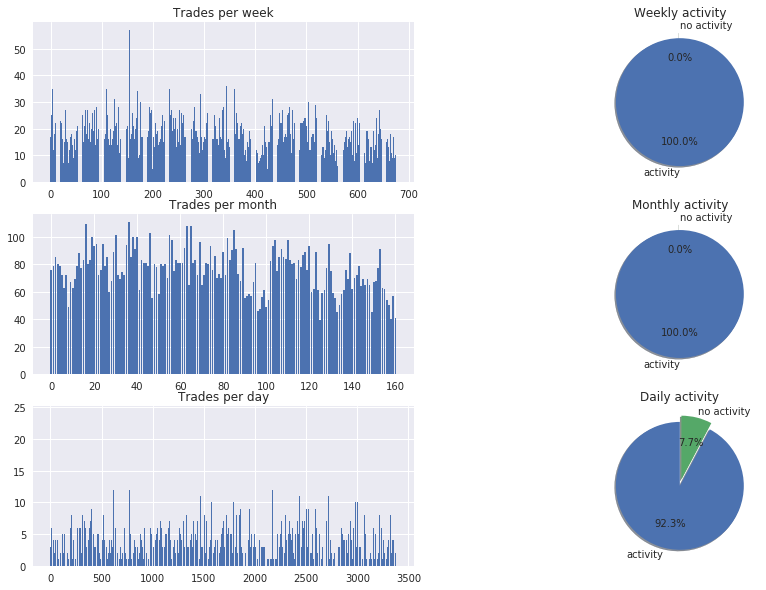

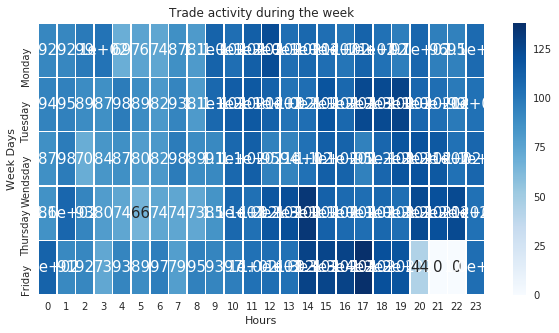

In [57]:
test=get_model_insights(model,history,0.3,X_test,Y_test,Y_dates_test)

In [58]:
Y_test

array([[0, 1],
       [0, 1],
       [1, 0],
       ...,
       [1, 0],
       [0, 1],
       [0, 1]])

In [59]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_13 (CuDNNLSTM)    (None, None, 64)          17920     
_________________________________________________________________
batch_normalization_11 (Batc (None, None, 64)          256       
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
cu_dnnlstm_14 (CuDNNLSTM)    (None, None, 64)          33280     
_________________________________________________________________
batch_normalization_12 (Batc (None, None, 64)          256       
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
cu_dnnlstm_15 (CuDNNLSTM)    (None, None, 12)         

In [60]:
from keras import regularizers

model = Sequential()  
model.add(layers.CuDNNLSTM(units = 32,return_sequences=True, input_shape = (None, X_train.shape[-1]),activity_regularizer=regularizers.l2(0.01))) 
model.add(layers.BatchNormalization()) 
model.add(layers.LeakyReLU()) 
model.add(Dropout(0.5)) 
model.add(layers.CuDNNLSTM(units = 12,activity_regularizer=regularizers.l2(0.01))) 
model.add(layers.BatchNormalization()) 
model.add(layers.LeakyReLU()) 
model.add(Dense(2)) 
model.add(layers.Activation('softmax'))


In [61]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1) 
model.compile(optimizer='sgd',loss='categorical_crossentropy', metrics=['accuracy'])

In [62]:
history = model.fit(X_train, Y_train, nb_epoch = 50,batch_size = 500, verbose=1, validation_data=(X_test, Y_test), shuffle=True, callbacks=[reduce_lr])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 9991 samples, validate on 81151 samples
Epoch 1/50
9991/9991 [==============================] - 3s 326us/step - loss: 12.9492 - acc: 0.4998 - val_loss: 3.9497 - val_acc: 0.5005
Epoch 2/50
9991/9991 [==============================] - 1s 120us/step - loss: 1.1789 - acc: 0.5007 - val_loss: 2.3000 - val_acc: 0.5000
Epoch 3/50
9991/9991 [==============================] - 1s 125us/step - loss: 0.9996 - acc: 0.4970 - val_loss: 1.6769 - val_acc: 0.4996
Epoch 4/50
9991/9991 [==============================] - 1s 123us/step - loss: 0.9070 - acc: 0.5040 - val_loss: 1.3878 - val_acc: 0.5009
Epoch 5/50
9991/9991 [==============================] - 1s 134us/step - loss: 0.8591 - acc: 0.5066 - val_loss: 1.2369 - val_acc: 0.5005
Epoch 6/50
9991/9991 [==============================] - 1s 135us/step - loss: 0.8289 - acc: 0.5003 - val_loss: 1.1783 - val_acc: 0.5019
Epoch 7/50
9991/9991 [==============================] - 2s 151us/step - loss: 0.8136 - acc: 0.4962 - val_loss: 1.0894 - val_acc: 0.501

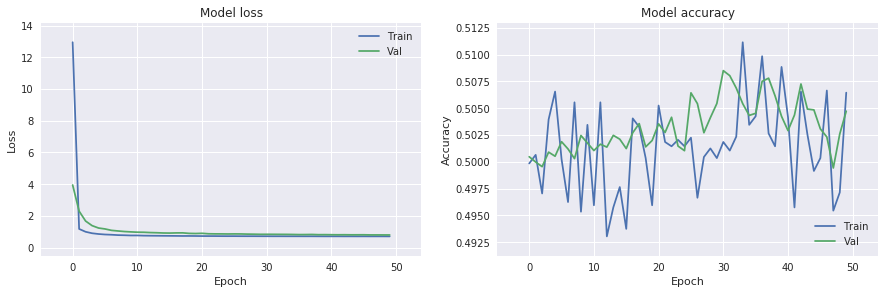

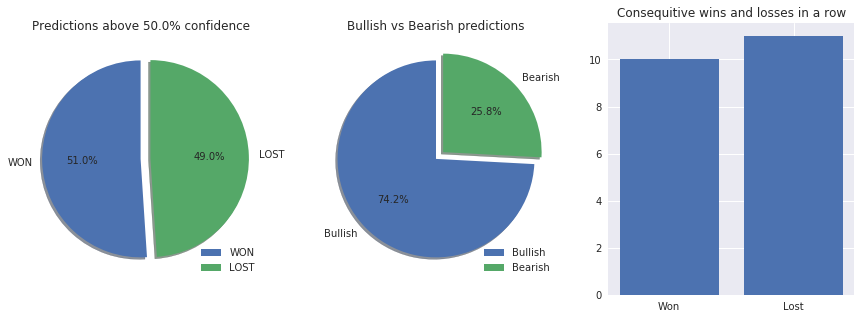

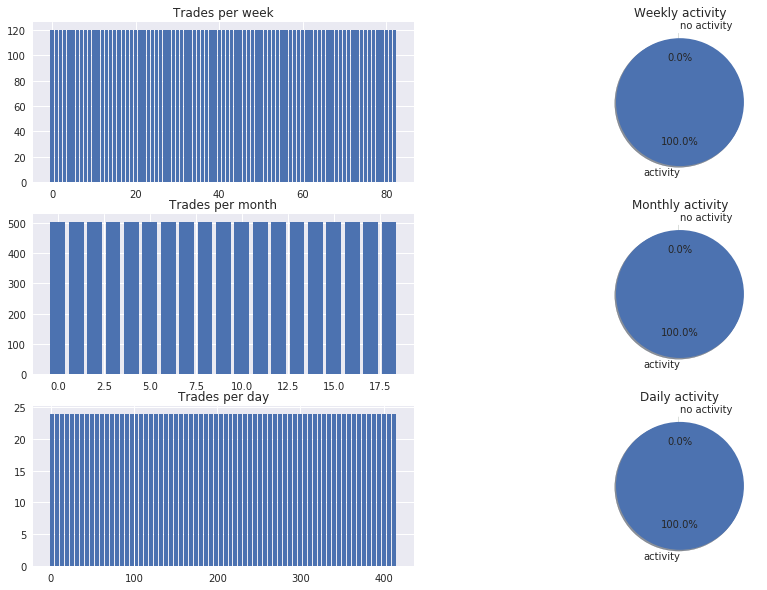

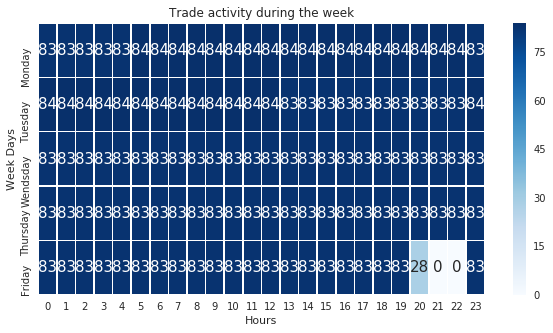

In [64]:
test=get_model_insights(model,history,0.5,X_val,Y_val,Y_dates_val)